# WFS - Web Feature Service

Eksempel på bruk av en offentlig tilgjengelig WFS-tjeneste:
- [Vannkraft WFS](https://kartkatalog.geonorge.no/metadata/vannkraft-wfs/4d65f0a5-e2c5-493c-b641-73c24577f685)


Denne presentasjonen kan lastes ned som Jupter Notebook-fil (høyreklikk, lagre som ..):

- [vannkraft.ipynb](docs/vannkraft.ipynb)

<pre>
NTNU 13.04.2021 - Sverre Stikbakke
</pre>

In [1]:
import requests            # for å sende http-kall
import xml.dom.minidom     # for å håndtere xml-filer
import geopandas as gpd    # for å vise GML-filer som kart

### Funksjon som sender kall til WFS-tjenesten
- url: url til WFS-tjeneste
- request: XML tekst-streng, kodet som byte-string med encode-funksjon
- outfile: filnavn på XML/GML-fil

In [2]:
def wfs_request(url, request, outfile):
    response = requests.post(url, request)
    doc = xml.dom.minidom.parseString(response.content.decode())
    xml_response = doc.toprettyxml()
    with open(outfile, 'w', encoding = 'utf-8') as f:
        f.write(xml_response)

## Url til tjenesten

In [3]:
url = 'https://wfs.geonorge.no/skwms1/wfs.vannkraft'

## GetCapabilities-kall

Utformingen av dette kallet er helt uavhengig av innholdet i tjenesten. Det brukes derfor samme kall til alle tjenester.
Vi er spesielt interessert i resultatet under `FeatureNameList`.

In [4]:
getcapabilities = """<?xml version="1.0" encoding="UTF-8"?>
<GetCapabilities
  service = "WFS"
  version = "2.0.0"
  xmlns = "http://www.opengis.net/wfs/2.0"
  xmlns:xsi = "http://www.w3.org/2001/XMLSchema-instance"
  xsi:schemaLocation = "http://www.opengis.net/wfs http://schemas.opengis.net/wfs/2.0/wfs.xsd"/>
""".encode()

## DescribeFeatureType

Dette kallet tilpasses den aktuelle tjenesten basert på resultatet av GetCapabilities-kallet.

- XML namespace, her: `xmlns:app="http://skjema.geonorge.no/SOSI/produktspesifikasjon/Vannkraft/1.3"`
- TypeName, her: `app:InnsjøRegulert`

Resultatet av kallet beskriver hvilke egenskaper (attributter) den aktuelle objekttypen (TypeName) har.


In [5]:
describefeaturetype = """<?xml version="1.0" encoding="UTF-8"?>
<DescribeFeatureType
  service = "WFS"
  version = "2.0.0"
  xmlns = "http://www.opengis.net/wfs/2.0"
  xmlns:app ="http://skjema.geonorge.no/SOSI/produktspesifikasjon/Vannkraft/1.3"
  xmlns:xsi = "http://www.w3.org/2001/XMLSchema-instance"
  xsi:schemaLocation = "http://www.opengis.net/wfs/2.0 http://schemas.opengis.net/wfs/2.0/wfs.xsd">
  <TypeName>app:InnsjøRegulert</TypeName>
</DescribeFeatureType>
""".encode()

## GetFeature - uten Filter Encoding

Dette kallet henter objekter fra tjenesten. Namespace og Typename må spesifiseres.
Her er det ikke noen spesifisering av hvordan objekter skal velges ut. Resultatet blir derfor tilfeldig, men det kan være en første test på å få ut et objekt fra tjenesten. Kallet spør i utgangspunktet etter alle objekter av den aktuelle objekttypen. Det er derfor viktig å begrense antallet objekter med `count`. Legg merke til:
- wfs:Query
- typeNames
- srsName

In [6]:
getfeature = """<?xml version="1.0" encoding="UTF-8"?>
<GetFeature
  service = "WFS"
  version = "2.0.0"
  count = "1"
  xmlns = "http://www.opengis.net/wfs/2.0"
  xmlns:app="http://skjema.geonorge.no/SOSI/produktspesifikasjon/Vannkraft/1.3">
  <Query typeNames = "app:InnsjøRegulert" srsName="urn:ogc:def:crs:EPSG::25832">
  </Query>
</GetFeature>
""".encode()

## GetFeature - med Filter Encoding

Dette kallet er utvidet med et `fes:Filter`-element. Filteret er av type BBOX som er oppgitt som en `gml:Envelope`.
`fes:ValueReference` henviser til `område` som er navnet på geometri-egenskapen i objekttypen. Denne opplysningen kunne vi finne basert på resultatet av DescribeFeatureType-kallet, under `InnsjøRegulert`. Legg merke til at kallet også er utvidet med to nye namespaces:

- xmlns:fes, for Filter Encoding
- xmlns:gml, for GML


In [7]:
getfeatureBBOX = """<?xml version="1.0" encoding="UTF-8"?>
<GetFeature
  version = "2.0.0"
  xmlns = "http://www.opengis.net/wfs/2.0"
  xmlns:fes = "http://www.opengis.net/fes/2.0"
  xmlns:gml="http://www.opengis.net/gml/3.2"
  xmlns:app="http://skjema.geonorge.no/SOSI/produktspesifikasjon/Vannkraft/1.3">
  <Query typeNames = "app:InnsjøRegulert"  srsName="urn:ogc:def:crs:EPSG::25832">
    <fes:Filter>
      <fes:BBOX>
        <fes:ValueReference>område</fes:ValueReference>
        <gml:Envelope srsName="urn:ogc:def:crs:EPSG::25832">
          <gml:lowerCorner>586500 6735500</gml:lowerCorner>
          <gml:upperCorner>596500 6745500</gml:upperCorner>
        </gml:Envelope>
      </fes:BBOX>
    </fes:Filter>
  </Query>
</GetFeature>
""".encode()

## Utføring av kallene

In [8]:
wfs_request(url, getcapabilities, 'getcapabilities.xml')

In [9]:
wfs_request(url, describefeaturetype, 'describefeaturetype.xml')

In [10]:
# wfs_request(url, getfeature, 'features.gml')

In [11]:
wfs_request(url, getfeatureBBOX, 'features.gml')

## Presentasjon av resultat-fil

In [12]:
# skjuler warnings i cellen nedenfor
import warnings
warnings.filterwarnings('ignore')

In [13]:
features = gpd.read_file('features.gml', download_schema="no")

In [14]:
features.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   gml_id                     1 non-null      object  
 1   lokalId                    1 non-null      object  
 2   navnerom                   1 non-null      object  
 3   versjonId                  1 non-null      float64 
 4   datauttaksdato             1 non-null      object  
 5   status                     1 non-null      object  
 6   konsesjonStatus            1 non-null      int64   
 7   konsesjonStatusDato        1 non-null      object  
 8   idriftsattAar              1 non-null      int64   
 9   vannkraftverkNr            1 non-null      int64   
 10  vannkraftverkNavn          1 non-null      object  
 11  elvenavnHierarki           1 non-null      object  
 12  magasinNr                  1 non-null      int64   
 13  magasinNavn                1 no

In [15]:
features.bounds

,minx,miny,maxx,maxy
0,574719.999,6677539.569,630586.005,6779617.995


In [16]:
features

,gml_id,lokalId,navnerom,versjonId,datauttaksdato,status,konsesjonStatus,konsesjonStatusDato,idriftsattAar,vannkraftverkNr,...,magasinAreal,volumOppdemt,magasinKategori,lavesteRegulerteVannstand,høyesteRegulerteVannstand,magasinFormål,kdbNr,spID,delfeltNr,geometry
0,app.innsjoregulert.649,3e5fb09f-1a45-44b1-82d9-d7a6bb061d9a,http://skjema.geonorge.no/SOSI/produktspesifik...,1.3,2021-04-13T05:36:46,D,5,2591-06-08T16:23:20,1912,349,...,375.82,1312,1,119.33,122.94,Kraftproduksjon,794,422,1905,"POLYGON ((574882.001 6779599.002, 574910.987 6..."


<AxesSubplot:>

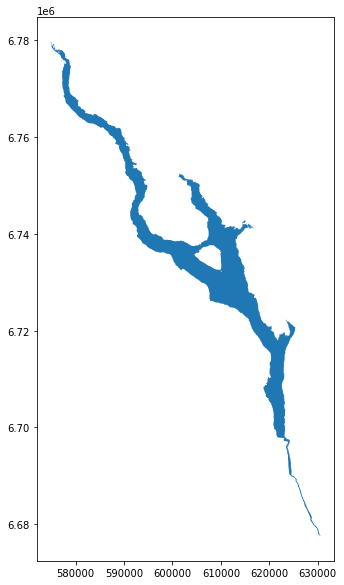

In [17]:
features.plot(figsize=(10,10))